In [1]:
# DNN

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

2.0.0


In [2]:
# 获取图片数据集
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all,y_train_all),(x_test,y_test) = fashion_mnist.load_data()
# 将训练集拆分为训练集和验证集 共60000张图片，前5000张为验证集，后55000张为训练集
x_valid,x_train = x_train_all[:5000],x_train_all[5000:]
y_valid,y_train = y_train_all[:5000],y_train_all[5000:]

print(x_valid.shape,y_valid.shape)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# x = (x - u)/std  u:均值  std:标准差
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# 进行转换：  只能对二位矩阵进行处理，所以要将三维矩阵先转为二维，之后再转换回去
# 又因为原数据为int型，因要做除法，所以先转为float型
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1,1)).reshape(-1,28,28) 

# scaler.fit_transform与scaler.transform的区别为前者会记录均值与标准差的值
# 当再用scaler.transform的时候就不用计算均值与标准差了
x_valid_scaled = scaler.transform(x_valid.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_test_scaled = scaler.transform(x_test.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)

In [4]:
#构建分类训练模型  深度神经网络

# tf.keras.models.Sequential()
# 定义一个顺序模型
model = keras.models.Sequential()

# 先将数据展开
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 循环定义深度网络层  20层
for _ in range(20):
    model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(10, activation='softmax'))

# 损失函数loss:用sparse是因为每个y_train是一个值，而不是一个向量，需要将其转换为[10,1]的向量
# 若y_train本来就是向量的话，损失函数用categorical_crossentropy
model.compile(loss='sparse_categorical_crossentropy', 
             optimizer = 'adam',
             metrics = ["accuracy"])    # 指标metrics  关系模型的精确度accuracy
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               78500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               1

In [5]:
# 这里使用三个callback函数，TensorBoard, EarlyStopping, ModelCheckpoint
# Tensorboard需要一个文件夹，ModelCheckpoint需要一个文件名
# logdir = './callbacks'  此处报错，改用下行
logdir = os.path.join("dnn-callbacks")
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5")

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True), # save_best_only保存最好的模型，否则保存最近的模型
#     如果连续5次迭代的变化值都小于min_delta，则停止训练
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
# 开始训练  返回值为训练过程中的历史数据, 可用于画图分析训练效果
history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid), callbacks = callbacks)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 27s 483us/sample - loss: 0.8821 - accuracy: 0.6366 - val_loss: 0.6017 - val_accuracy: 0.7686
Epoch 2/10
55000/55000 [==============================] - 21s 374us/sample - loss: 0.6332 - accuracy: 0.7697 - val_loss: 0.6130 - val_accuracy: 0.7926
Epoch 3/10
55000/55000 [==============================] - 22s 399us/sample - loss: 0.5823 - accuracy: 0.7855 - val_loss: 0.5562 - val_accuracy: 0.8074
Epoch 4/10
55000/55000 [==============================] - 19s 353us/sample - loss: 0.5723 - accuracy: 0.7944 - val_loss: 0.5874 - val_accuracy: 0.7826
Epoch 5/10
55000/55000 [==============================] - 18s 330us/sample - loss: 0.5205 - accuracy: 0.8198 - val_loss: 0.4798 - val_accuracy: 0.8408
Epoch 6/10
55000/55000 [==============================] - 17s 312us/sample - loss: 0.5295 - accuracy: 0.8157 - val_loss: 0.4742 - val_accuracy: 0.8428
Epoch 7/10
55000/55000 [=====================

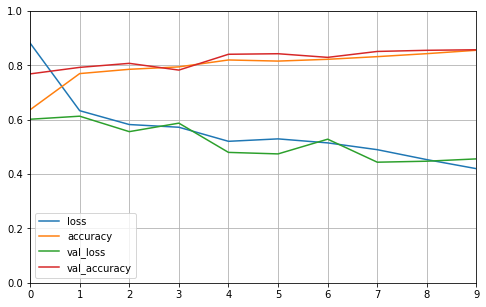

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
# 当前的图表和子图可以使用plt.gcf()和plt.gca()获得，分别表示"Get Current Figure"和"Get Current Axes"
# 设置y坐标的上下限
    plt.gca().set_ylim(0, 1)  
    plt.show()
    
plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled, y_test)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.4840714852809906, 0.8386]